# Hotspot propensity vs entropy from Fig 3B and 3C

In [1]:
import os
from collections import defaultdict
import json

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from scipy.stats import entropy

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
data_dir = '../../../data'

In [4]:
sigs_color = {
'SBS1': '#1e79baff',
 'SBS2': '#ff9896ff',
 'SBS3': '#f6c200ff', 
 'SBS4': '#00a572ff', 
 'SBS5': '#7ebdeaff',
 'SBS7a': '#8c564bff', 
 'SBS7b': '#c49c94ff',
 'SBS8': '#3dbe3dff',
 'SBS13': '#d62728ff',
 'SBS17a': '#ffbb78ff',
 'SBS17b': '#ff8921ff', 
 'SBS18': '#9467bdff',
 'SBS40': '#c2e0f5ff',
 'SBS93': '#c5b0d5ff',
}

In [5]:
signatures_to_plot = list(sigs_color.keys())

### Load data

Input data corresponds to Dataset EV5, a table containing observed hotspot propensity calculations using 100 samples and 100-300 mutations per sample for 1000 iterations and a JSON file containing expected (theoretical) hotspot propensity. 

This expected was computed using the model of homogeneous distribution of trinucleotide-specific mutation rates with 300 mutations/sample and 100 samples across mappable megabases. .

In [6]:
# Signature profiles
sig_profiles_f = os.path.join(data_dir, 'EV_datasets', 'EV5_table.txt')
sig_profiles_df = pd.read_csv(sig_profiles_f, sep='\t', header=0)
sig_profiles_df.head(3)

,Mutation_type,Trinucleotide,Trinucleotide_genome_frequency,SBS1,SBS2,SBS3,SBS4,SBS5,SBS7a,SBS7b,...,SBS5_normalised,SBS7a_normalised,SBS7b_normalised,SBS8_normalised,SBS13_normalised,SBS17a_normalised,SBS17b_normalised,SBS18_normalised,SBS40_normalised,SBS93_normalised
0,A[C>A]A,ACA,0.040418,0.000876,5.790059e-07,0.020920,0.042451,0.012052,0.000067,0.002344,...,0.006892,0.000035,0.001182,0.032109,0.001397,0.001856,0.000603,0.026066,0.021034,0.007795
1,A[C>A]C,ACC,0.022682,0.002220,1.455045e-04,0.016343,0.032990,0.009337,0.000177,0.000457,...,0.009514,0.000164,0.000411,0.061074,0.000971,0.001444,0.000224,0.014034,0.017539,0.009569
2,A[C>A]G,ACG,0.004613,0.000180,5.361861e-05,0.001808,0.016116,0.001908,0.000073,0.000192,...,0.009561,0.000334,0.000849,0.030270,0.001824,0.000384,0.000519,0.011068,0.019599,0.010671


In [7]:
# Observed hotspot propensity
propensity_f = f'{data_dir}/hotspot_propensity_1000iter_100samples_100-300muts.txt.gz'
propensity_df = pd.read_csv(propensity_f, sep='\t', header=0)
propensity_df.head()

,ITER,N_SAMPLES,TOTAL_HOTSPOTS,TOTAL_HOTSPOTS_UNIQPOS,TOTAL_MUTS,CTYPE,SIGNATURE
0,BLADDER_URI_iter_0_SBS2,100,0,0,10000,BLADDER_URI,SBS2
1,BLADDER_URI_iter_1_SBS2,100,1,1,10000,BLADDER_URI,SBS2
2,BLADDER_URI_iter_2_SBS2,100,0,0,10000,BLADDER_URI,SBS2
3,BLADDER_URI_iter_3_SBS2,100,2,2,10000,BLADDER_URI,SBS2
4,BLADDER_URI_iter_4_SBS2,100,2,2,10000,BLADDER_URI,SBS2


In [8]:
len(propensity_df)

279000

In [9]:
# Expected hotspot propensity
theoretical_propensity_f = f'{data_dir}/expected_hotspot_propensity/expected_hotspots_genomewide_disallowed.json'
with open(theoretical_propensity_f, 'r') as fd: 
    theoretical_propensity_data = json.load(fd)

In [10]:
# Reformat into a dictionary for easy access
theoretical_propensity_d = defaultdict(lambda: defaultdict(dict))
for element in theoretical_propensity_data: 
    muts, sig, samples, hotspots = element
    if str(samples)[-2] == '0': 
        theoretical_propensity_d[muts][sig][samples] = hotspots

### Compute entropy of normalised signatures' profiles

In [11]:
mutation_types = sig_profiles_df['Mutation_type'].tolist()
mutation_types_reformat = [m[0]+m[2]+m[-1]+'>'+m[-3] for m in mutation_types]
len(mutation_types_reformat), mutation_types_reformat[:3]

(96, ['ACA>A', 'ACC>A', 'ACG>A'])

In [12]:
entropy_d = {}
norm_profiles_d = {}
for signature in signatures_to_plot:
    # Get normalised profile 
    norm_profile = sig_profiles_df[f'{signature}_normalised'].tolist()
    norm_profiles_d[signature] = dict(list(zip(mutation_types_reformat, norm_profile)))
    # Compute entropy
    norm_profile_entropy = entropy(norm_profile)
    entropy_d[signature] = norm_profile_entropy

### Compute observed hotspot propensity per signature

In [13]:
# Use only subsamplings with 300 mutations per sample across 100 samples (= 30000 total mutations)
subset = propensity_df.loc[propensity_df['TOTAL_MUTS'] == 30000].copy()
subset.sort_values(by='TOTAL_HOTSPOTS_UNIQPOS', ascending=False, inplace=True)
subset.head()

,ITER,N_SAMPLES,TOTAL_HOTSPOTS,TOTAL_HOTSPOTS_UNIQPOS,TOTAL_MUTS,CTYPE,SIGNATURE
259640,COADREAD_iter_640_SBS17b,100,129,129,30000,COADREAD,SBS17b
259565,COADREAD_iter_565_SBS17b,100,120,120,30000,COADREAD,SBS17b
259916,COADREAD_iter_916_SBS17b,100,119,119,30000,COADREAD,SBS17b
259824,COADREAD_iter_824_SBS17b,100,119,119,30000,COADREAD,SBS17b
259425,COADREAD_iter_425_SBS17b,100,119,119,30000,COADREAD,SBS17b


In [14]:
data_to_plot = dict()
for signature, data in subset.groupby('SIGNATURE'): 
    median = np.median(data['TOTAL_HOTSPOTS_UNIQPOS'])
    first_quartile = np.percentile(data['TOTAL_HOTSPOTS_UNIQPOS'], 25)
    third_quartile = np.percentile(data['TOTAL_HOTSPOTS_UNIQPOS'], 75)
    data_to_plot[signature] = (median, first_quartile, third_quartile)
data_to_plot

{'SBS1': (39.0, 34.0, 44.0),
 'SBS13': (4.0, 2.0, 5.0),
 'SBS17a': (72.0, 62.0, 81.0),
 'SBS17b': (78.0, 69.0, 89.0),
 'SBS18': (7.0, 5.0, 8.0),
 'SBS2': (6.0, 4.0, 7.0),
 'SBS3': (1.0, 0.0, 2.0),
 'SBS4': (1.0, 0.0, 2.0),
 'SBS40': (1.0, 0.0, 2.0),
 'SBS5': (2.0, 1.0, 3.0),
 'SBS7a': (7.0, 6.0, 9.0),
 'SBS7b': (3.5, 2.0, 5.0),
 'SBS8': (6.0, 4.0, 8.0),
 'SBS93': (6.0, 5.0, 8.0)}

## Panel 3B

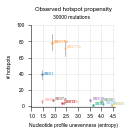

In [15]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.set_ylabel('# hotspots', fontsize=5)
ax.set_xlabel('Nucleotide profile unevenness (entropy)', fontsize=5)
plt.title(f'Observed hotspot propensity', fontsize=6, y=1.1)
plt.suptitle('30000 mutations', fontsize=5)

legend_elements = []
entropy = []
hotspots = []
for signature in signatures_to_plot: 
    color = sigs_color.get(signature, 'grey')
    x = entropy_d[signature]
    median, error_min, error_max = data_to_plot[signature]
    error_min = 0 if error_min < 0 else error_min
    ax.plot(x, median, '.', markersize=5, linewidth=0, markeredgewidth=0, color=color, alpha=0.75, zorder=3)
    ax.plot([x, x], [error_min, error_max], ls='-', lw=0.5, c='grey', zorder=1)
    legend_elements.append(Line2D([0], [0], marker='s', color='w', label=signature, markerfacecolor=color, markersize=5))
    ax.annotate(s=signature, xy=(x, median), xytext=(x+0.1, median+0.1), fontsize=4, color=color)
    entropy.append(-x)
    hotspots.append(median)
    
ax.set_ylim(-1, 100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(ax.get_yticks(), fontsize=5)
ax.set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])
ax.set_xticklabels(ax.get_xticks(), fontsize=5)

ax.spines['left'].set(lw=0.5)
ax.spines['bottom'].set(lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.yaxis.get_ticklines(), 'markeredgewidth', 0.5)
plt.setp(ax.xaxis.get_ticklines(), 'markeredgewidth', 0.5)
ax.set_axisbelow(True)
ax.grid(color='lightgrey', linestyle='--', linewidth=0.5, zorder=0)
plt.rc('axes', edgecolor='black')

for extension in ['png']: 
    output = f'./fig_3B.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 3C

In [16]:
# Select parameters of theoretical hotspot propensity
sample_muts = 300 
sample_size = 100
theoretical_propensity_selected_d = {}
for signature, data in theoretical_propensity_d[sample_muts].items(): 
    if signature in signatures_to_plot: 
        theoretical_propensity_selected_d[signature] = data[sample_size]
theoretical_propensity_selected_d

{'SBS8': 0.17446386162369595,
 'SBS5': 0.1426547362630986,
 'SBS3': 0.09395065238712713,
 'SBS7a': 1.5768101628022724,
 'SBS17b': 1.8091686011195667,
 'SBS40': 0.09409000328332445,
 'SBS2': 2.244392562753391,
 'SBS93': 0.16100825597126936,
 'SBS18': 0.3836918517122858,
 'SBS4': 0.29589774792217993,
 'SBS7b': 1.0794757680081797,
 'SBS17a': 1.2788436883547256,
 'SBS1': 11.841720844099429,
 'SBS13': 1.3417561075896642}

In [17]:
fcs = []
sbs1_exp = theoretical_propensity_selected_d['SBS1']
for s, exp in theoretical_propensity_selected_d.items(): 
    if s != 'SBS1': 
        fcs.append((s, sbs1_exp/exp))

In [18]:
sorted(fcs, key=lambda tup: tup[1])

[('SBS2', 5.2761361985499375),
 ('SBS17b', 6.545393744270945),
 ('SBS7a', 7.509921690924786),
 ('SBS13', 8.825538991115115),
 ('SBS17a', 9.259709338937421),
 ('SBS7b', 10.969881117340375),
 ('SBS18', 30.862580978078814),
 ('SBS4', 40.01963829482663),
 ('SBS8', 67.8749211091122),
 ('SBS93', 73.54728968812934),
 ('SBS5', 83.00965782348582),
 ('SBS40', 125.85524955761304),
 ('SBS3', 126.04192246909773)]

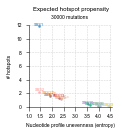

In [19]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.set_ylabel('# hotspots', fontsize=5)
ax.set_xlabel('Nucleotide profile unevenness (entropy)', fontsize=5)
title = plt.title(f'Expected hotspot propensity', fontsize=6, y=1.1)
plt.suptitle('30000 mutations', fontsize=5)

legend_elements = []
hotspots = []
for signature in signatures_to_plot: 
    color = sigs_color.get(signature, 'grey')
    x = entropy_d[signature]
    y = theoretical_propensity_selected_d[signature]
    plt.plot(x, y, '.', markersize=5, linewidth=0, markeredgewidth=0, color=color, alpha=0.75, zorder=1)
    ax.text(x, y + 0.2, signature, rotation=0, fontsize=4, color=color, va='center', ha='center')
    legend_elements.append(Line2D([0], [0], marker='s', color='w', label=signature, markerfacecolor=color, markersize=5))
    hotspots.append(y)

ax.set_ylim(-0, 12)
ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax.set_yticklabels([0, 2, 4, 6, 8, 10, 12], fontsize=5)
ax.set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])
ax.set_xticklabels(ax.get_xticks(), fontsize=5)

ax.spines['left'].set(lw=0.5)
ax.spines['bottom'].set(lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.yaxis.get_ticklines(), 'markeredgewidth', 0.5)
plt.setp(ax.xaxis.get_ticklines(), 'markeredgewidth', 0.5)
ax.set_axisbelow(True)
ax.grid(color='lightgrey', linestyle='--', linewidth=0.5, zorder=0)

for extension in ['png']: 
    output = f'./fig_3C.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)